In [1]:
import sys
import os
import cpa
import scanpy as sc


[rank: 0] Global seed set to 0


In [54]:
data_path = 'data/kang_normalized_hvg.h5ad'
adata = sc.read(data_path)

In [64]:
adata

AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov'
    layers: 'counts'

In [40]:
adata.X = adata.layers['counts'].copy()

In [41]:
# We will create a dummy dosage variable for each condition (control, IFN-beta stimulated). 
# It is recommended to use Identity (i.e. doser_type = 'identity') for dosage scaling function when there is no dosage information available.

adata.obs['dose'] = adata.obs['condition'].apply(lambda x: '+'.join(['1.0' for _ in x.split('+')]))
adata.obs['cell_type'].value_counts()


CD14 Mono    4362
CD4 T        4266
B            1366
CD16 Mono    1044
CD8 T         814
T             633
NK            619
DC            472
Name: cell_type, dtype: int64

In [42]:
adata.obs['condition'].value_counts()

stimulated    7217
ctrl          6359
Name: condition, dtype: int64

In [43]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition',
                      control_group='ctrl',
                      dosage_key='dose',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=1,
                     )

100%|██████████| 16/16 [00:00<00:00, 1900.29it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [44]:
model_params = {
    "n_latent": 64,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.0,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [39]:
model = cpa.CPA(adata=adata, 
                split_key='split_B',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **model_params,
               )

[rank: 0] Global seed set to 6977


In [40]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=200,
            check_val_every_n_epoch=200,
            save_path='models/',
           )

100%|██████████| 2/2 [00:00<00:00, 99.66it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 200/2000:  10%|▉         | 199/2000 [06:07<54:50,  1.83s/it, v_num=1, recon=598, r2_mean=0.945, adv_loss=2.34, acc_pert=0.527, acc_cell_type=0.383]  


Epoch 00199: cpa_metric reached. Module best state updated.



disnt_basal = 0.6444116357494659
disnt_after = 1.540407259536634
val_r2_mean = 0.9021972815195719
val_r2_var = 0.529795949988895
Epoch 400/2000:  20%|█▉        | 399/2000 [12:15<49:20,  1.85s/it, v_num=1, recon=550, r2_mean=0.952, adv_loss=2.33, acc_pert=0.531, acc_cell_type=0.371, val_recon=783, disnt_basal=0.644, disnt_after=1.54, val_r2_mean=0.902, val_KL=nan]


Epoch 00399: cpa_metric reached. Module best state updated.



disnt_basal = 0.6385561094870492
disnt_after = 1.5437572197923413
val_r2_mean = 0.8938150657547844
val_r2_var = 0.5358985397550794
Epoch 600/2000:  30%|██▉       | 599/2000 [18:25<43:27,  1.86s/it, v_num=1, recon=526, r2_mean=0.956, adv_loss=2.32, acc_pert=0.548, acc_cell_type=0.37, val_recon=850, disnt_basal=0.639, disnt_after=1.54, val_r2_mean=0.894, val_KL=nan] 
disnt_basal = 0.6379124153033563
disnt_after = 1.5456052612367561
val_r2_mean = 0.8877686381340025
val_r2_var = 0.49699886375003394
Epoch 800/2000:  40%|███▉      | 799/2000 [24:34<37:26,  1.87s/it, v_num=1, recon=513, r2_mean=0.959, adv_loss=2.32, acc_pert=0.547, acc_cell_type=0.377, val_recon=896, disnt_basal=0.638, disnt_after=1.55, val_r2_mean=0.888, val_KL=nan]
disnt_basal = 0.6456622733745796
disnt_after = 1.540152767095617
val_r2_mean = 0.8939598586824206
val_r2_var = 0.4626522329118517
Epoch 1000/2000:  50%|████▉     | 999/2000 [30:44<31:14,  1.87s/it, v_num=1, recon=505, r2_mean=0.96, adv_loss=2.31, acc_pert=0.559,

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [1:01:28<00:00,  1.84s/it, v_num=1, recon=489, r2_mean=0.964, adv_loss=2.29, acc_pert=0.567, acc_cell_type=0.381, val_recon=1.02e+3, disnt_basal=0.635, disnt_after=1.54, val_r2_mean=0.874, val_KL=nan]


In [45]:
pretrained = True
if pretrained: 
    model = cpa.CPA(adata=adata, 
                    split_key='split_B',
                    train_split='train',
                    valid_split='valid',
                    test_split='ood',
                    **model_params,
                   )
    # Load the pre-trained model
    model = model.load('models', adata=adata)

[rank: 0] Global seed set to 6977


INFO     File models/model.pt already downloaded                                                                   


100%|██████████| 16/16 [00:00<00:00, 1916.57it/s]
[rank: 0] Global seed set to 6977


In [9]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)
latent_outputs.keys()

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

In [10]:
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-07-24 13:20:18.617082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/OpenSSL/1.1/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2024-07-24 13:20:18.617933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/ai.mila.quebec/apps/arch/distro/OpenSSL/1.1/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libreadline/7.0/lib:/cvmfs/ai.mila.quebec/apps/arch/distro/libffi/3.2.1/lib
2024-07-24 13:20:18.617945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libr

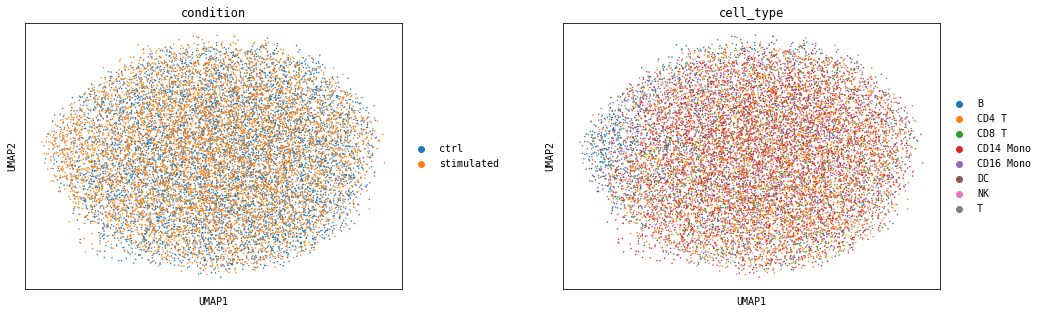

In [11]:

sc.pl.umap(latent_outputs['latent_basal'], 
           color=['condition', 'cell_type'],
           frameon=True, 
           wspace=0.3,
)


In [12]:
sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


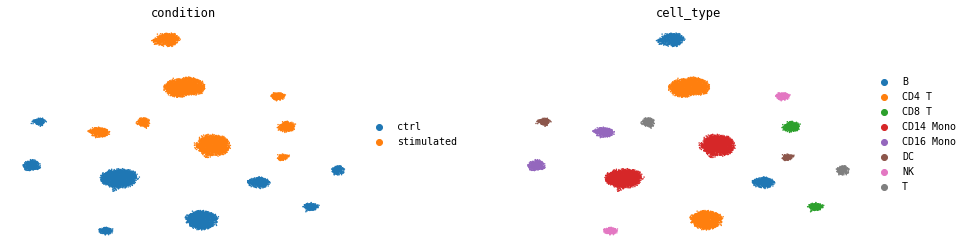

In [13]:
sc.pl.umap(latent_outputs['latent_after'], 
           color=['condition', 'cell_type'], 
           frameon=False,
           wspace=0.3)

In [46]:
model.predict(adata, batch_size=2048)

100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


In [53]:
adata

AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK', 'dose', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_type', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'

In [16]:
def get_DEG_with_direction(gene, score):
    if score > 0:
        return(f'{gene}+')
    else:
        return(f'{gene}-')

def to_dense(X):
    if issparse(X):
        return X.toarray()
    else:
        return np.asarray(X)

def get_DEGs(control_adata, target_adata):
    temp_concat = anndata.concat([control_adata, target_adata], label = 'batch')
    sc.tl.rank_genes_groups(temp_concat, 'batch', method='wilcoxon', 
                                groups = ['1'], ref = '0', rankby_abs = True)

    rankings = temp_concat.uns['rank_genes_groups']
    result_df = pd.DataFrame({'scores': rankings['scores']['1'],
                     'pvals_adj': rankings['pvals_adj']['1']},
                    index = rankings['names']['1'])
    return result_df

def get_eval(true_adata, pred_adata, DEGs, DEG_vals, pval_threshold):
        
    results_dict =  {}
    
    true_mean = to_dense(true_adata.X).mean(axis = 0)
    true_var = to_dense(true_adata.X).var(axis = 0)
    
    pred_mean = to_dense(pred_adata.X).mean(axis = 0)
    pred_var = to_dense(pred_adata.X).var(axis = 0)
    
    true_corr_mtx = np.corrcoef(to_dense(true_adata.X), rowvar=False).flatten()
    true_cov_mtx = np.cov(to_dense(true_adata.X), rowvar=False).flatten()
        
    pred_corr_mtx = np.corrcoef(to_dense(pred_adata.X), rowvar=False).flatten()
    pred_cov_mtx = np.cov(to_dense(pred_adata.X), rowvar=False).flatten()

    results_dict['all_genes_mean_R2'] = scipy.stats.pearsonr(true_mean, pred_mean)[0]**2
    results_dict['all_genes_var_R2'] = scipy.stats.pearsonr(true_var, pred_var)[0]**2
    results_dict['all_genes_mean_MSE'] = (np.square(true_mean - pred_mean)).mean(axis=0)
    results_dict['all_genes_var_MSE'] = (np.square(true_var - pred_var)).mean(axis=0)
   
    corr_nas = np.logical_or(np.isnan(true_corr_mtx), np.isnan(pred_corr_mtx))
    cov_nas = np.logical_or(np.isnan(true_cov_mtx), np.isnan(pred_cov_mtx))
        
    results_dict['all_genes_corr_mtx_R2'] = scipy.stats.pearsonr(true_corr_mtx[~corr_nas], pred_corr_mtx[~corr_nas])[0]**2
    results_dict['all_genes_cov_mtx_R2'] = scipy.stats.pearsonr(true_cov_mtx[~cov_nas], pred_cov_mtx[~cov_nas])[0]**2
    results_dict['all_genes_corr_mtx_MSE'] = (np.square(true_corr_mtx[~corr_nas] - pred_corr_mtx[~corr_nas])).mean(axis=0)
    results_dict['all_genes_cov_mtx_MSE'] = (np.square(true_cov_mtx[~cov_nas] - pred_cov_mtx[~cov_nas])).mean(axis=0)

    significant_DEGs = DEGs[DEGs['pvals_adj'] < pval_threshold]
    num_DEGs = len(significant_DEGs)
    DEG_vals.insert(0, num_DEGs)
    
    for val in DEG_vals:
        if ((val > num_DEGs) or (val == 0)):
            results_dict[f'Top_{val}_DEGs_mean_R2'] = None
            results_dict[f'Top_{val}_DEGs_var_R2'] = None
            results_dict[f'Top_{val}_DEGs_mean_MSE'] = None
            results_dict[f'Top_{val}_DEGs_var_MSE'] = None
                        
            results_dict[f'Top_{val}_DEGs_corr_mtx_R2'] = None
            results_dict[f'Top_{val}_DEGs_cov_mtx_R2'] = None
            results_dict[f'Top_{val}_DEGs_corr_mtx_MSE'] = None
            results_dict[f'Top_{val}_DEGs_cov_mtx_MSE'] = None
        
        else:
            top_DEGs = significant_DEGs[0:val].index
        
            true_mean = to_dense(true_adata[:,top_DEGs].X).mean(axis = 0)
            true_var = to_dense(true_adata[:,top_DEGs].X).var(axis = 0)
            true_corr_mtx = np.corrcoef(to_dense(true_adata[:,top_DEGs].X), rowvar=False).flatten()
            true_cov_mtx = np.cov(to_dense(true_adata[:,top_DEGs].X), rowvar=False).flatten()

            pred_mean = to_dense(pred_adata[:,top_DEGs].X).mean(axis = 0)
            pred_var = to_dense(pred_adata[:,top_DEGs].X).var(axis = 0)
            pred_corr_mtx = np.corrcoef(to_dense(pred_adata[:,top_DEGs].X), rowvar=False).flatten()
            pred_cov_mtx = np.cov(to_dense(pred_adata[:,top_DEGs].X), rowvar=False).flatten()

            results_dict[f'Top_{val}_DEGs_mean_R2'] = scipy.stats.pearsonr(true_mean, pred_mean)[0]**2
            results_dict[f'Top_{val}_DEGs_var_R2'] = scipy.stats.pearsonr(true_var, pred_var)[0]**2
            results_dict[f'Top_{val}_DEGs_mean_MSE'] = (np.square(true_mean - pred_mean)).mean(axis=0)
            results_dict[f'Top_{val}_DEGs_var_MSE'] = (np.square(true_var - pred_var)).mean(axis=0)
            
            corr_nas = np.logical_or(np.isnan(true_corr_mtx), np.isnan(pred_corr_mtx))
            cov_nas = np.logical_or(np.isnan(true_cov_mtx), np.isnan(pred_cov_mtx))
            
            results_dict[f'Top_{val}_DEGs_corr_mtx_R2'] = scipy.stats.pearsonr(true_corr_mtx[~corr_nas], pred_corr_mtx[~corr_nas])[0]**2
            results_dict[f'Top_{val}_DEGs_cov_mtx_R2'] = scipy.stats.pearsonr(true_cov_mtx[~cov_nas], pred_cov_mtx[~cov_nas])[0]**2
            results_dict[f'Top_{val}_DEGs_corr_mtx_MSE'] = (np.square(true_corr_mtx[~corr_nas] - pred_corr_mtx[~corr_nas])).mean(axis=0)
            results_dict[f'Top_{val}_DEGs_cov_mtx_MSE'] = (np.square(true_cov_mtx[~cov_nas] - pred_cov_mtx[~cov_nas])).mean(axis=0)

    return results_dict

def get_DEG_Coverage_Recall(true_DEGs, pred_DEGs, p_cutoff):
    sig_true_DEGs = true_DEGs[true_DEGs['pvals_adj'] < p_cutoff]
    true_DEGs_with_direction = [get_DEG_with_direction(gene,score) for gene, score in zip(sig_true_DEGs.index, sig_true_DEGs['scores'])]
    sig_pred_DEGs = pred_DEGs[pred_DEGs['pvals_adj'] < p_cutoff]
    pred_DEGs_with_direction = [get_DEG_with_direction(gene,score) for gene, score in zip(sig_pred_DEGs.index, sig_pred_DEGs['scores'])]
    num_true_DEGs = len(true_DEGs_with_direction)
    num_pred_DEGs = len(pred_DEGs_with_direction)
    num_overlapping_DEGs = len(set(true_DEGs_with_direction).intersection(set(pred_DEGs_with_direction)))
    if num_true_DEGs > 0: 
        COVERAGE = num_overlapping_DEGs/num_true_DEGs
    else:
        COVERAGE = None
    if num_pred_DEGs > 0:
        RECALL = num_overlapping_DEGs/num_pred_DEGs
    else:
        RECALL = None
    return COVERAGE, RECALL

def get_DEGs_overlaps(true_DEGs, pred_DEGs, DEG_vals, pval_threshold):
    true_DEGs_for_comparison = [get_DEG_with_direction(gene,score) for gene, score in zip(true_DEGs.index, true_DEGs['scores'])]   
    pred_DEGs_for_comparison = [get_DEG_with_direction(gene,score) for gene, score in zip(pred_DEGs.index, pred_DEGs['scores'])]

    significant_DEGs = true_DEGs[true_DEGs['pvals_adj'] < pval_threshold]
    num_DEGs = len(significant_DEGs)
    DEG_vals.insert(0, num_DEGs)
    
    results = {}
    for val in DEG_vals:
        if val > num_DEGs:
            results[f'Overlap_in_top_{val}_DEGs'] = None
        else:
            results[f'Overlap_in_top_{val}_DEGs'] = len(set(true_DEGs_for_comparison[0:val]).intersection(set(pred_DEGs_for_comparison[0:val])))

    return results

In [19]:
MAX_P_VAL = 0.05
P_VAL_ITERS = 1000
REPLICATES = 10

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm
import anndata
from scipy.sparse import issparse
import scipy

n_top_degs = [10, 20, 50] # None means all genes

#results = defaultdict(list)
r2_mses = {}
c_r = {}
deg_overlap = {}
for cat in tqdm(adata.obs['cov_cond'].unique()):
    if 'ctrl' not in cat:
        cov, condition = cat.split('_')
        cat_adata = adata[adata.obs['cov_cond'] == f'{cov}_stimulated'].copy()
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cat_adata.layers['counts']
        x_pred = cat_adata.obsm['CPA_pred'].clip(min=0)
        x_ctrl = ctrl_adata.layers['counts']
        
            
        # Convert x_ctrl_deg and x_true_deg to AnnData objects
        x_true_deg_adata = anndata.AnnData(X=x_true)
        x_true_deg_adata.var_names = adata.var_names
        
        x_pred_deg_adata = anndata.AnnData(X=x_pred)
        x_pred_deg_adata.var_names = adata.var_names
        
        x_ctrl_deg_adata = anndata.AnnData(X=x_ctrl)
        x_ctrl_deg_adata.var_names = adata.var_names
            

        # Ensure the AnnData objects have unique observation names
            
        #x_true_deg_adata.obs_names = [f"true_{i}" for i in range(x_true.shape[0])]
        #x_pred_deg_adata.obs_names = [f"true_{i}" for i in range(x_pred.shape[0])]
        #x_ctrl_deg_adata.obs_names = [f"ctrl_{i}" for i in range(x_ctrl.shape[0])]
            
            
        true_DEGs_df = get_DEGs(x_ctrl_deg_adata, x_true_deg_adata)
        pred_DEGs_df = get_DEGs(x_ctrl_deg_adata, x_pred_deg_adata)
    
        r2_and_mse = get_eval(x_true_deg_adata, x_pred_deg_adata, true_DEGs_df, [50,20,10], 0.05)
        c_r_results = {p: get_DEG_Coverage_Recall(true_DEGs_df, pred_DEGs_df, p) for p in [x/P_VAL_ITERS for x in range(1,int(P_VAL_ITERS*MAX_P_VAL))]}
        DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [50,20,10], 0.05)
        
        r2_mses[cat] = r2_and_mse
        c_r[cat] = c_r_results
        deg_overlap[cat] = DEGs_overlaps
        




  0%|          | 0/16 [00:00<?, ?it/s]

 56%|█████▋    | 9/16 [00:04<00:03,  2.24it/s]

 62%|██████▎   | 10/16 [00:13<00:09,  1.62s/it]

 69%|██████▉   | 11/16 [00:17<00:10,  2.06s/it]

 75%|███████▌  | 12/16 [00:25<00:12,  3.14s/it]

 81%|████████▏ | 13/16 [00:28<00:09,  3.24s/it]

 88%|████████▊ | 14/16 [00:32<00:06,  3.35s/it]

 94%|█████████▍| 15/16 [00:35<00:03,  3.28s/it]

100%|██████████| 16/16 [00:39<00:00,  2.45s/it]


In [34]:
adata.obs['cov_cond'].unique()

['CD14 Mono_ctrl', 'CD4 T_ctrl', 'T_ctrl', 'CD8 T_ctrl', 'B_ctrl', ..., 'CD14 Mono_stimulated', 'T_stimulated', 'NK_stimulated', 'DC_stimulated', 'CD16 Mono_stimulated']
Length: 16
Categories (16, object): ['B_ctrl', 'B_stimulated', 'CD4 T_ctrl', 'CD4 T_stimulated', ..., 'NK_ctrl', 'NK_stimulated', 'T_ctrl', 'T_stimulated']

In [69]:
counts_array = x_true
np.count_nonzero(counts_array)

134957

In [21]:
deg_overlap

{'CD8 T_stimulated': {'Overlap_in_top_60_DEGs': 0,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DEGs': 0},
 'CD4 T_stimulated': {'Overlap_in_top_160_DEGs': 0,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DEGs': 0},
 'B_stimulated': {'Overlap_in_top_122_DEGs': 0,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DEGs': 0},
 'CD14 Mono_stimulated': {'Overlap_in_top_445_DEGs': 1,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DEGs': 0},
 'T_stimulated': {'Overlap_in_top_63_DEGs': 0,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DEGs': 0},
 'NK_stimulated': {'Overlap_in_top_67_DEGs': 0,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DEGs': 0},
 'DC_stimulated': {'Overlap_in_top_208_DEGs': 1,
  'Overlap_in_top_50_DEGs': 0,
  'Overlap_in_top_20_DEGs': 0,
  'Overlap_in_top_10_DE

## Use metrics from the CPA paper

In [27]:


n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
for cat in tqdm(adata.obs['cov_cond'].unique()):
    if 'ctrl' not in cat:
        cov, condition = cat.split('_')
        cat_adata = adata[adata.obs['cov_cond'] == cat].copy()
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cat_adata.layers['counts']
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts']

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
            
            results['condition'].append(condition)
            results['cell_type'].append(cov)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

100%|██████████| 16/16 [00:02<00:00,  7.14it/s]


In [28]:
df

,condition,cell_type,n_top_deg,r2_mean_deg,r2_var_deg,r2_mean_lfc_deg,r2_var_lfc_deg
0,stimulated,CD8 T,10,0.968734,-5.510772,0.953827,-3.720618
1,stimulated,CD8 T,20,0.966244,-3.338331,0.952136,-2.683301
2,stimulated,CD8 T,50,0.963114,-0.071148,0.948264,-1.587336
3,stimulated,CD8 T,all,0.969658,0.704472,0.902404,-0.505670
4,stimulated,CD4 T,10,0.958190,-39.407845,0.942185,-1.801268
5,stimulated,CD4 T,20,0.960694,-5.734141,0.944622,-1.855414
6,stimulated,CD4 T,50,0.968244,0.066937,0.958352,-1.190602
7,stimulated,CD4 T,all,0.970850,0.630178,0.915704,-0.754519
8,stimulated,B,10,0.753734,0.032967,0.598498,0.268082
9,stimulated,B,20,0.799733,-0.321582,0.734147,-0.029574
